In [ ]:
#Imports

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import numpy as np
import shap

For this binary prediction task, I have decided to use the decision tree classifier. The latter is indeed a 'white box' model, as it is highly interpretable and its functiong and choises for each data point can be deeply investigated and explained.
Furthermore, the decision tree classifier is one of the best model for classification tasks. 
A decision tree is also capable of working with missing values, and this dataset contains a non-negligible number of them.

Note: the request of challenge 2 specifies that the probability of an employee not to be loyal. I will provide the code for having the model to return a probability, and I will apply it on the predictions on the test set, on which the best model configuration will be tested. I will put it at the end of the document. 
The predictions that you will see on the validation set will be binary predictions: I am doing this for model comparison, and because the binary classification evaluation metrics that I'll be using, require binarized predictions 


In [2]:
# This is a custom function aimed at displayig the most importan metrics for a binary classification, together with a confusion matrix
# The input for this function must be binary predictions

def evaluate(y_pred, y_validation):
    cm = confusion_matrix(y_validation, y_pred)
    acc = accuracy_score(y_validation,y_pred)
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    beta = 0.5

    if tp == 0 and fp == 0:
        precision = 0.0
        F1 = 0.0
    else:
        precision = tp / (tp + fp)
        F1 = (1+beta**2)*((precision * recall)/((beta**2 * precision) + recall))
        
    print("Confusion Matrix:")
    print("{:>10} {:>10} {:>10}".format("", "Predicted 0", "Predicted 1"))
    print("{:>10} {:>10} {:>10}".format("Actual 0", tn, fp))
    print("{:>10} {:>10} {:>10}".format("Actual 1", fn, tp))
    print("Recall:", round(recall, 3))
    print("Precision:", round(precision, 3))
    print("Accuracy:", round(acc, 4))
    print("F1 score:", round(F1, 4))


In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/leotasso3/Xtream_Tasso/main/datasets/employee-churn/churn.csv")  # Reading the dataset

# isolating the target variable, which is in the last column of the dataset
y = df.iloc[:, -1]

# The predictors will be all the other variables, but for the city (explanation below) and the ID column 
x = df.iloc[:, 1:13]
x=x.drop('city', axis=1)

I have decided to split the dataset into training (70%), validation (15%) and test set (15%). The training set will be indeed used for training the DT to build its nodes and leaves. 
I want to try different configuration of the model, starting from a baseline one with the (almost) untouched dataset, for then moving to hyperparameter optimization, PCA and feature selection. This is why the validation set is here. After training the model, I will test the performance of the latter on the validation data, and as I want to try different configuration, I will do it more than once. 
The metrics obtained on the validation set will be used for selecting the model configuration that yielded the best results. That model will then be tested on the test set: this will give the opportunity to evaluate the generalization of the model on unseen data.
Without the validation set, testing different models configurations on the test set would could lead to overfitting, as doing this would basically mean to adapt the choice of the best model configuration on future data, which of course is not possible in reality. 
As the dataset is slightly imbalanced, I will apply stratification with respect to the target variable, so that the same proportion of the latter will be present in every set

In [5]:
# Set creation and stratification (the randon_state is for reproducibility purposes)
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.18, random_state=42, stratify=y_train_temp)


# Verification of stratification
print("Distribution of the target variable in the training set:", y_train.value_counts(normalize=True))
print("Distribution of the target variable in the validation set:", y_val.value_counts(normalize=True))
print("Distribution of the target variable in the test set:", y_test.value_counts(normalize=True))

Distribution of the target variable in the training set: target
0.0    0.750674
1.0    0.249326
Name: proportion, dtype: float64
Distribution of the target variable in the validation set: target
0.0    0.750682
1.0    0.249318
Name: proportion, dtype: float64
Distribution of the target variable in the test set: target
0.0    0.750522
1.0    0.249478
Name: proportion, dtype: float64


As the DecisionTreeClassifier won't work with 'object' as variable type (categorical), I will apply dummy encoding.
This will increase the dimensionality of the dataset and could therefore increment the computational costs for the model training.
For an eventual future dataset way larger than the one provided here, it is advisable to apply PCA or feature selection (which will in any case tested on this dataset as well).
The reasons why I have decided to remove the 'city' column are mainly 2: 
-This variable has 73 classes, and dummy coding it would result in a severe increase in the dimensionality of the dataset, which of course is not positive either for computational costs and risk of overfitting
-Stratify this variable could be very difficult: if there are very few people coming from one city, it could be that the relative coded column won't be present in all the 3 sets, which of course will lead to an error of model training or model prediction.


In [47]:
categorical_columns = x_train.select_dtypes(include=['object']).columns.tolist() # Storing the categorical variable

# Dummy coding the categorical variables in all the 3 sets 
x_train_encoded = pd.get_dummies(x_train, columns=categorical_columns) 
x_val_encoded = pd.get_dummies(x_val, columns=categorical_columns)
x_test_encoded = pd.get_dummies(x_test, columns=categorical_columns)


The following cell is aimed at computing the baseline results on the validation set. These results will be used as a reference for eventual improvements after parameters tuning.

In [49]:
model = DecisionTreeClassifier()
model.fit(x_train_encoded, y_train)
pred = model.predict(x_val_encoded)
evaluate(pred, y_val)

Confusion Matrix:
           Predicted 0 Predicted 1
  Actual 0       1804        397
  Actual 1        388        343
Recall: 0.469
Precision: 0.464
Accuracy: 0.7323
F1 score: 0.4646


In the following cell, hyperparameters tuning is applied. I have decided to use the 'grid search' method, which goes across all the possible combination of the sets of the given parameters. In this case, I have decided to test for the nodes division criterion, the maximum depth of the tree, and the minimum number of samples for a split, which consists of the minumum number of points that need to belong to the same classes before a node division.

In [50]:
hyperparameters = {
    "criterion":['gini', 'entropy'],
    "max_depth":[10,15,20,30,35,40,45],
    'min_samples_split': [20, 30, 40]
}

grid_search = GridSearchCV(model, param_grid = hyperparameters, cv = 10)

grid_search.fit(x_train_encoded, y_train)

grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 40}

The next cells is aimed at the training and evaluation (on the validation set) of the model with the best parameters found after HP optimization

In [51]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=40)
model.fit(x_train_encoded, y_train)
pred = model.predict(x_val_encoded)
evaluate(pred, y_val)

Confusion Matrix:
           Predicted 0 Predicted 1
  Actual 0       1862        339
  Actual 1        341        390
Recall: 0.534
Precision: 0.535
Accuracy: 0.7681
F1 score: 0.5347


Now, I will try to apply a principal component analysis (PCA): this algorithm is aimed at dimensionality reduction with a parallel try to keep the variability of the predictor as high as possible.

In [52]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_encoded)
x_val_scaled = scaler.fit_transform(x_val_encoded)

# Applica la PCA sulle variabili dopo l'encoding
pca = PCA(n_components=20)  # Sostituisci 'numero_di_componenti' con il numero desiderato di componenti
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.fit_transform(x_val_scaled)

# Fitting and evaluation of the model (with optimized HP) with predictors post PCA
model = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=40)
model.fit(x_train_pca, y_train)
pred = model.predict(x_val_pca)
evaluate(pred, y_val)


Confusion Matrix:
           Predicted 0 Predicted 1
  Actual 0       1829        372
  Actual 1        493        238
Recall: 0.326
Precision: 0.39
Accuracy: 0.705
F1 score: 0.3753


Now, I will apply feature selection, with the 'SelectKBest' function. With a k = 15, this function will provide the 15 best predictors for this model. Like PCA, this activity is aimed at dimensionality reduction and it may lead to higher performances of the model

In [54]:
selector = SelectKBest(score_func=f_classif, k=15)  # Sostituisci 'k' con il numero desiderato di caratteristiche
x_selected = selector.fit_transform(x_train_encoded, y_train)

selected_columns = selector.get_support()  # Print this value if you want to see the selected columns 

# Ottieni l'elenco delle colonne selezionate utilizzando l'array booleano
all_columns = x_train_encoded.columns.tolist()  # Sostituisci con i nomi reali delle colonne
selected_column_names = [column for column, selected in zip(all_columns, selected_columns) if selected]

x_val_selected = x_val_encoded[selected_column_names]

model = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=40)
model.fit(x_selected, y_train)
pred = model.predict(x_val_selected)
evaluate(pred, y_val)



Confusion Matrix:
           Predicted 0 Predicted 1
  Actual 0       1927        274
  Actual 1        393        338
Recall: 0.462
Precision: 0.552
Accuracy: 0.7725
F1 score: 0.5316


/Users/leo/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


I will now try to train the model (on the training set) on data without missing values. Of course, this can't be applied on the validation set (and eventually neither on the test set). 
The reason why I am not trying to apply imputations techniques on missing data, it's because we are dealing mostly with categorical data, and being the most reasonable way to impute missing categorical data the substitution with the mode, it wouldn't be a wise choice with this dataset. The reason is that this most of the variables of this dataset are imbalanced (there is a class which constitutes the majority of the data points for that column), and substituting missing data with the mode would lead to use almost always the majority class, and it wouldn't be realistic 

In [55]:
#REMOVE NA VALUES, TRAIN AND TEST 


x_train_clean = x_train.dropna()
y_train_clean = y_train.loc[x_train_clean.index]

x_train_clean_encoded = pd.get_dummies(x_train_clean, columns=categorical_columns) 

new_columns = x_train_clean_encoded.columns
x_val_encoded = x_val_encoded[new_columns]
model = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=40)
model.fit(x_train_clean_encoded, y_train_clean)
pred = model.predict(x_val_encoded)
evaluate(pred, y_val)

Confusion Matrix:
           Predicted 0 Predicted 1
  Actual 0       1977        224
  Actual 1        466        265
Recall: 0.363
Precision: 0.542
Accuracy: 0.7647
F1 score: 0.4931


Discussion: 

Starting from the baseline result, where we obtained a 73% accuracy (73% out of all the data points classified correctly) and a 47% recall (47% of the positive class correctly classified), the best improvement has been obtained after hyperparameter optimization, with a 77% accuracy and a 53% recall.
Applying PCA didn't lead to any improvement, while feature selection allowed an increase in just the accuracy.
I will now evaluate the generalization capability of the model with the optimized hyperparameters on the test set. Before doing this, I will train the model on the combination of the validation and training set, for an eventual further improvement of the training 



In [7]:
# Evaluation on test set

x_train_full_encoded = pd.get_dummies(x_train_temp, columns=categorical_columns) # X_train_temp was created at the first train 
                                                                                 # test split and comprehends also the actual validaiton set

model = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_split=40)
model.fit(x_train_full_encoded, y_train_temp)

predicted_probabilities = model.predict_proba(X = x_test_encoded, check_input=True)  # This array will contained the predicted probabilities from the test set data


pred = model.predict(x_test_encoded) # I will anyway compute the binary predictions for evaluation purposes
evaluate(pred, y_test)


Confusion Matrix:
           Predicted 0 Predicted 1
  Actual 0       1793        364
  Actual 1        244        473
Recall: 0.66
Precision: 0.565
Accuracy: 0.7884
F1 score: 0.5818


The results on the validation set are even better than what we obtained before.
This means that the model generalized pretty well, and also manage to have a reduction especially in the false negative errors (as the higher recall shows).

CHALLENGE 3

Explainability of the model:
I will first provide a plot of the last decision tree that has been used on the test set. From that graph, it will be possible to visualize all the nodes and the leaves.
Note that here in jupyther notebook it won't be possible to read the criteria of the nodes directly from the following image. Insights about it are provided after this. The next graph is here just for giving an idea of how the model is structured.
Each node consists in a decision that considers a single variable and compares each data point's relative value with the threshold for that node. 
Each decision corresponds to either a right or left branch of the node, which can lead to either another decision node, or to a leaf node. The latter nodes are the ones where the decisions are mode and the data point are classified.


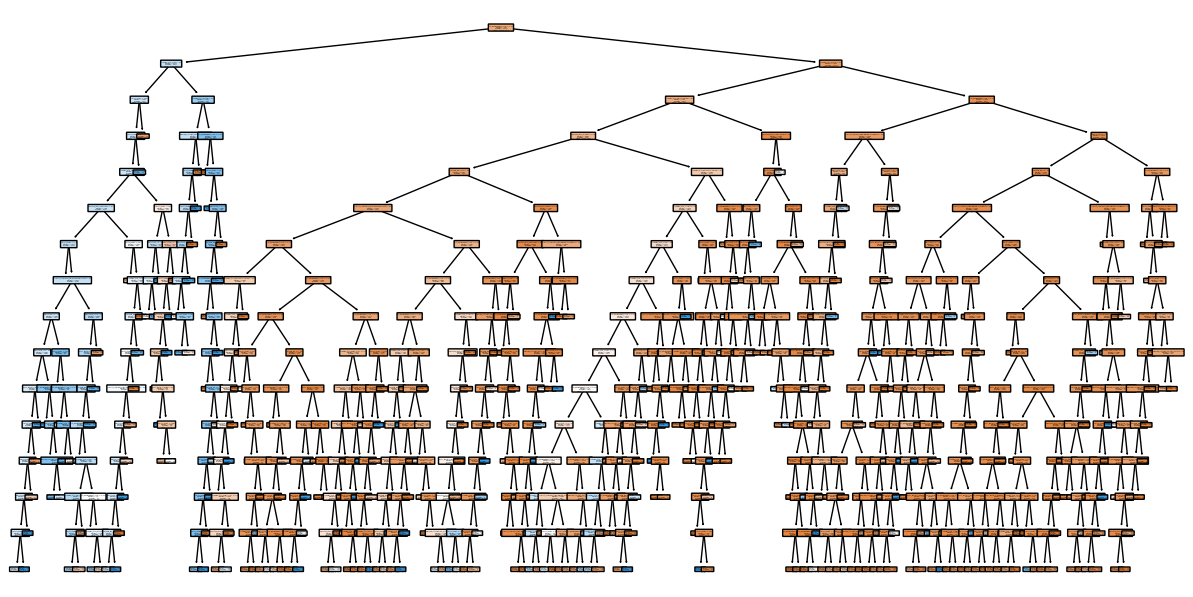

In [14]:
#Plot of the three
plt.figure(figsize = (15, 7.5))
tree_visuazlizaiton = plot_tree(model,
          filled = True,
          rounded = True,
          feature_names = x_train_encoded.columns)

In a machine learning model like this, some features exercise 'higher weights' for the data point classification, meaning that some variables have a stronger influence for the final decision of the model.
Below, you can see a SHAP analysis for the first data point of the test set. The SHAP analysis is indeed aimed at provide explainability for a model decision, highlighting the influcence that each variable had for a specific prediction.
The f(x) values is the predicted probability (further explanation in the code cell). The values associated to each variable represents the magnitude of the influence that that variable had in the model for the prediction.


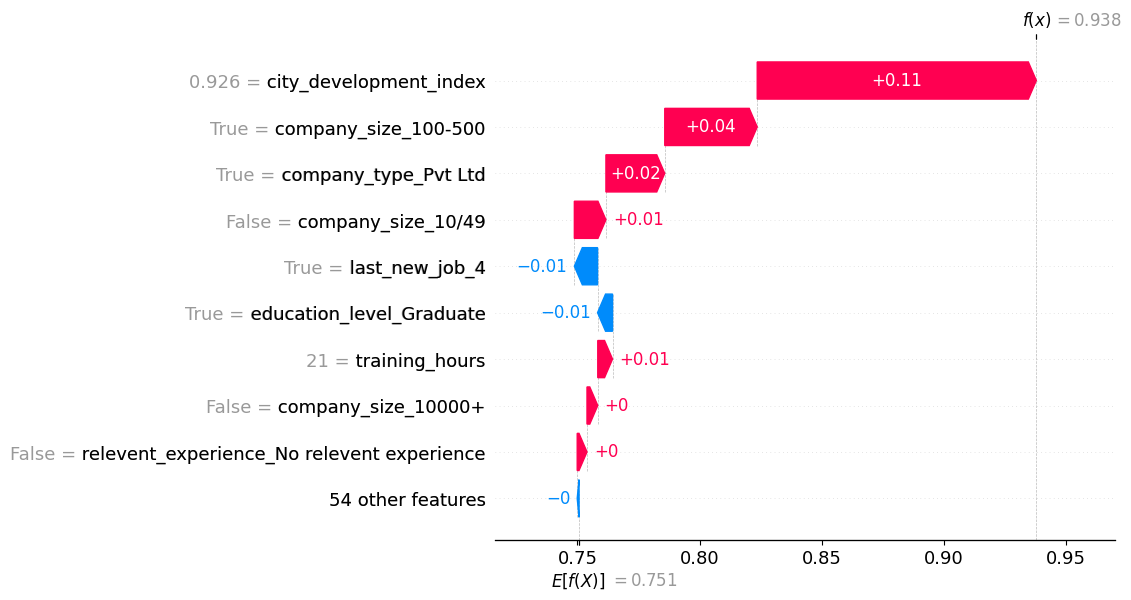

In [115]:
# Initializing the shap object on the test set
shap.initjs() 
explainer = shap.Explainer(model)
shap_values = explainer(x_test_encoded)

# in the square parenthesis, the first value is the index of the data point of the test set for which you are going to see the SHAP 
# analysis. You can change it for investigating different data points. The right most value can be either 1 or 0: if it's 0, you will
# see in f(x) the probability that the model has predicted for that data point to belong to the negative class, 
# with the relative (in red) influence that each variable had for reaching that prediction value.
# Same thing if you put 1, of course f(x) is the probability of the data point to belong to the positive class, and the bars will be blue
# If you see negative values for same variables, it means that those values had a negative influence towards the prediction.
shap.plots.waterfall(shap_values[0,:,0])


For further explanation, below I have provided the code that shows the path a data point has taken in the decision tree.
It's possible to observe all the nodes through which the data point has passed, along with the respective variable that was compared to the threshold determining the direction that the data point would have taken.
Effectively, this way breaks down the path an instance takes until reaching the final prediction. It's possible to observe all the variables that have been 'queried' by the model for that specific employee, with their respective values for each variable.

In [151]:

instance_index = 0 # Here you specify the instance for which you want to investigate the path in the decision tree.

# Get the decision path for each point of the test data in a matrix
node_indicator = model.decision_path(x_test_encoded)

# Get the leaf node id (every node in the decision tree has an ID) for the instance of interest
leaf_id = model.apply(x_test_encoded)[instance_index]

# storing in the node_indexes array the list of nodes (nodes indexes) that the data point went through 
node_indexes = node_indicator.indices[node_indicator.indptr[instance_index]:node_indicator.indptr[instance_index + 1]]

# Get the decision_tree data structure attribute
deicision_tree = model.tree_

# Get features used in each nodes
features_in_nodes = deicision_tree.feature[node_indexes]

# Get the names of the columns corresponding to the feature indices 
feature_names = x_train_encoded.columns
names_of_features_in_nodes = feature_names[features_in_nodes]


# This code will print the list of nodes that the data point went across, and for each node you will also see 
# the feature that was 'evaluated', the threshold value set by the model, and the actual value for that data point, 
# so that you can understand how the path in the tree has been.

for node in node_indexes:
    print(f"Node {node}:")
    print(f"  Feature for decision: {feature_names[deicision_tree.feature[node]]}")
    print(f"  Threshold: {deicision_tree.threshold[node]}")
    print(f"  Value for this instance: {x_test_encoded.iloc[[instance_index]][feature_names[deicision_tree.feature[node]]].values[0]}")

print(f"Final prediction: {y_test.iloc[instance_index]}")

Node 0:
  Feature for decision: city_development_index
  Threshold: 0.6245000064373016
  Value for this instance: 0.926
Node 134:
  Feature for decision: company_type_Pvt Ltd
  Threshold: 0.5
  Value for this instance: True
Node 522:
  Feature for decision: city_development_index
  Threshold: 0.7915000021457672
  Value for this instance: 0.926
Node 588:
  Feature for decision: experience_3
  Threshold: 0.5
  Value for this instance: False
Node 589:
  Feature for decision: last_new_job_4
  Threshold: 0.5
  Value for this instance: True
Node 719:
  Feature for decision: relevent_experience_Has relevent experience
  Threshold: 0.5
  Value for this instance: True
Node 721:
  Feature for decision: company_size_10/49
  Threshold: 0.5
  Value for this instance: False
Node 722:
  Feature for decision: city_development_index
  Threshold: 0.815500020980835
  Value for this instance: 0.926
Node 724:
  Feature for decision: city_development_index
  Threshold: 0.8379999995231628
  Value for this in